In [1]:
import pandas as pd 
import numpy as np 
import pickle 
import torch as t
from sklearn.model_selection import train_test_split

In [2]:
with open('data/datasets/curated_dataset_full.pkl', 'rb') as file:
    data = pickle.load(file)


In [5]:
data['filename'].unique()
remainder = data[~data['filename'].isin(['common_claim_true_false.csv', 'companies_true_false.csv', 'counterfact_true_false.csv'])]

In [9]:
with open('data/datasets/coherence/neg_dataset.pkl', 'rb') as f:
       other_dataset = pickle.load(f)

other_dataset

,statement,new_statement,label,filename,neg_label
0,Spiders can use surface tension to walk on water.,Spiders cannot use surface tension to walk on ...,1,neg_common_claim_true_false.csv,0
1,Claw ticks were once used as a form of torture.,Claw ticks were not once used as a form of tor...,1,neg_common_claim_true_false.csv,0
2,A military brat is a colloquial term for a chi...,A military brat is not a colloquial term for a...,1,neg_common_claim_true_false.csv,0
3,Mice can fall from a fifth story window and wa...,Mice cannot fall from a fifth story window and...,1,neg_common_claim_true_false.csv,0
4,"Male turkeys (""tom turkeys"") often sport extre...","Male turkeys (""tom turkeys"") do not often spor...",1,neg_common_claim_true_false.csv,0
...,...,...,...,...,...
20054,Arnold Hague originates from Boston.,Arnold Hague does not originate from Boston.,1,neg_counterfact_true_false.csv,0
16768,Blanca de Silos holds a citizenship from Spain.,Blanca de Silos does not hold a citizenship fr...,1,neg_counterfact_true_false.csv,0
30602,Matthew Pratt died in the city of Philadelphia.,Matthew Pratt did not die in the city of Phila...,1,neg_counterfact_true_false.csv,0
30750,Brock Lesnar professionally plays the sport fo...,Brock Lesnar does not professionally play the ...,1,neg_counterfact_true_false.csv,0


In [18]:
curated_dataset = pd.concat([remainder, other_dataset])

In [22]:
curated_dataset

,statement,label,filename,new_statement,neg_label
0,It is the case either that the city of Nanded ...,1,cities_cities_disj.csv,NaN,NaN
1,It is the case either that the city of Casabla...,1,cities_cities_disj.csv,NaN,NaN
2,It is the case either that the city of Taguig ...,1,cities_cities_disj.csv,NaN,NaN
3,It is the case either that the city of Maturin...,1,cities_cities_disj.csv,NaN,NaN
4,It is the case either that the city of Jilin i...,1,cities_cities_disj.csv,NaN,NaN
...,...,...,...,...,...
20054,Arnold Hague originates from Boston.,1,neg_counterfact_true_false.csv,Arnold Hague does not originate from Boston.,0.0
16768,Blanca de Silos holds a citizenship from Spain.,1,neg_counterfact_true_false.csv,Blanca de Silos does not hold a citizenship fr...,0.0
30602,Matthew Pratt died in the city of Philadelphia.,1,neg_counterfact_true_false.csv,Matthew Pratt did not die in the city of Phila...,0.0
30750,Brock Lesnar professionally plays the sport fo...,1,neg_counterfact_true_false.csv,Brock Lesnar does not professionally play the ...,0.0


In [23]:
train_set, test_set = train_test_split(curated_dataset, test_size=0.3, random_state=42, stratify=curated_dataset['filename'])
test_df = test_set.dropna()
# Plug negations in training set

extra_rows = (
                train_set
                .loc[train_set["new_statement"].notna() & train_set["neg_label"].notna(),
                    ["new_statement", "neg_label"]]
                .rename(columns={"new_statement": "statement",
                                "neg_label": "label"})
            )

train_set = pd.concat(
    [train_set[["statement", "label"]], extra_rows],
    ignore_index=True
)   

In [24]:
train_set

,statement,label
0,It is the case both that the city of Mumbai is...,0.0
1,Fifty-two is larger than seventy-six.,0.0
2,It is the case both that the city of Anyang is...,1.0
3,The city of Ryazan' is not in South Korea.,1.0
4,Diamonds are not actually as rare as people th...,1.0
...,...,...
18164,The law in Autonomous Republic of Crimea does ...,1.0
18165,Automobiles were not invented before tires.,1.0
18166,Penguins cannot balance an egg on top of a pen...,1.0
18167,Bad loans do not lead to good outcomes.,1.0


In [5]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import seaborn as sns
import pandas as pd
import einops
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
from sklearn.base import clone
import os
from datetime import datetime
import torch as t

In [16]:
def plot_line(x, title="DummyTitle", x_axis="Layer", y_axis="Accuracy", label="Model"):

    fig, ax = plt.subplots(figsize=(12, 8), facecolor='w')
    ax.set_facecolor('#e0e0e0')
    ax.plot(x, color='#007acc', alpha=0.7, marker='o',
            markersize=8, linewidth=2.5, label=label)

    ax.set_title(title, fontsize=18, pad=20, weight='bold', color='#333333')
    ax.set_xlabel(x_axis, fontsize=14, labelpad=10, color='#333333')
    ax.set_ylabel(y_axis, fontsize=14, labelpad=10, color='#333333')

    ax.grid(visible=True, which='major', color='#f7f7f7',
            linewidth=1.5, linestyle='--')
    ax.tick_params(axis='both', which='major',
                   labelsize=12, color='#555555')

    legend = ax.legend(fontsize=12, loc='upper right', frameon=True)
    legend.get_frame().set_facecolor('#ffffff')
    legend.get_frame().set_edgecolor('#e0e0e0')
    legend.get_frame().set_alpha(0.9)

    for spine in ax.spines.values():
        spine.set_visible(False)

    plt.tight_layout()
    # save_fig(f"line_{title}")


def plot_heat(accuracies, title="DummyTitle", x_axis="Heads (Sorted)",
              y_axis="Layers (Bottom-Up)", model="Model", probe="Probe"):

    accuracies = np.array(accuracies)
    sorted_accuracies = np.sort(accuracies, axis=1)[:, ::-1]
    sorted_accuracies = sorted_accuracies[::-1, :]

    norm = colors.Normalize(
        vmin=sorted_accuracies.min(),
        vmax=max(sorted_accuracies.max(), 0.75)
    )

    plt.figure(figsize=(10, 8))
    sns.set(style="whitegrid")
    ax = sns.heatmap(
        sorted_accuracies,
        annot=False,
        fmt=".2f",
        cmap="cividis",
        cbar_kws={"shrink": 0.9, "aspect": 22},
        linewidths=0,
        linecolor="white",
        norm=norm
    )

    num_layers = sorted_accuracies.shape[0]
    num_heads = sorted_accuracies.shape[1]

    ax.set_yticks(np.arange(num_layers) + 0.5)
    ax.set_yticklabels(np.arange(num_layers - 1, -1, -1), fontsize=10)
    ax.set_xticks([])

    plt.suptitle(title, fontsize=18)
    plt.title(f"Model: {model} | Probe: {probe}")
    plt.xlabel(x_axis, fontsize=12, labelpad=10)
    plt.ylabel(y_axis, fontsize=12, labelpad=10)

    ax.hlines(np.arange(1, num_layers), *ax.get_xlim(),
              colors="white", linestyles="solid", linewidth=0.2)
    ax.vlines(np.arange(1, num_heads), *ax.get_ylim(),
              colors="white", linestyles="solid", linewidth=0.2)

    plt.tight_layout()
    # save_fig(f"heat_{title}")

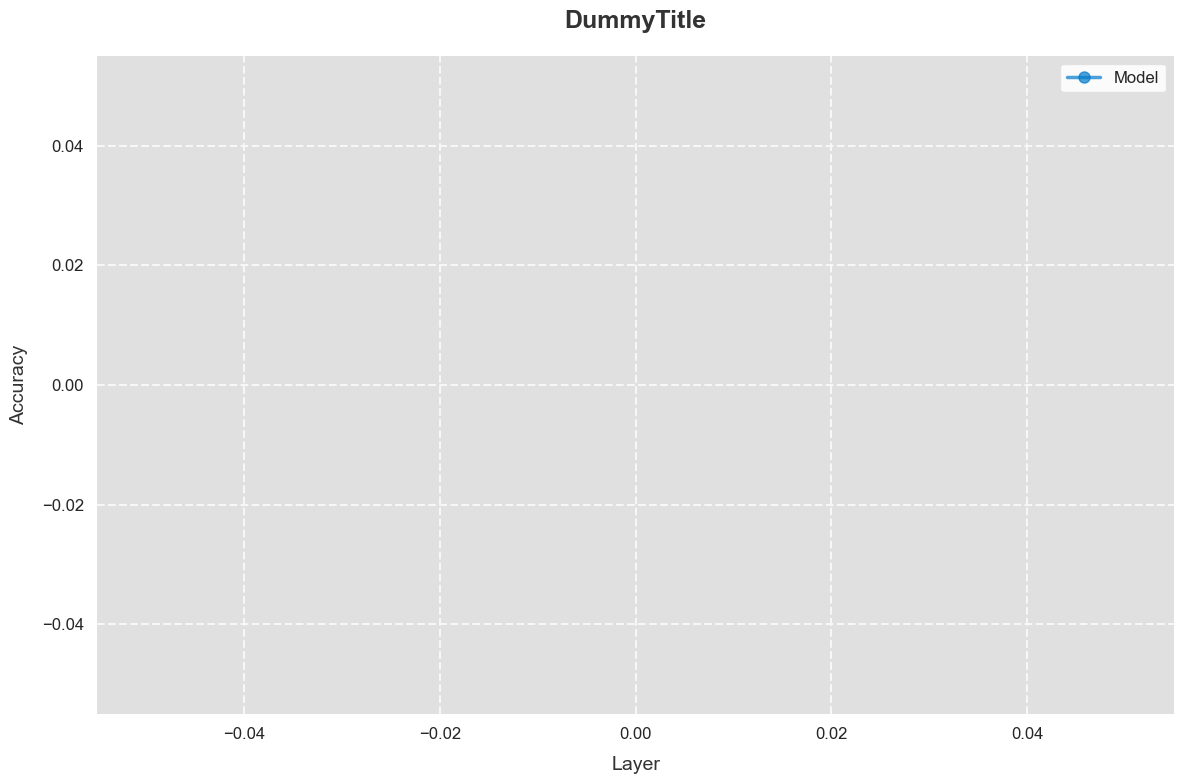

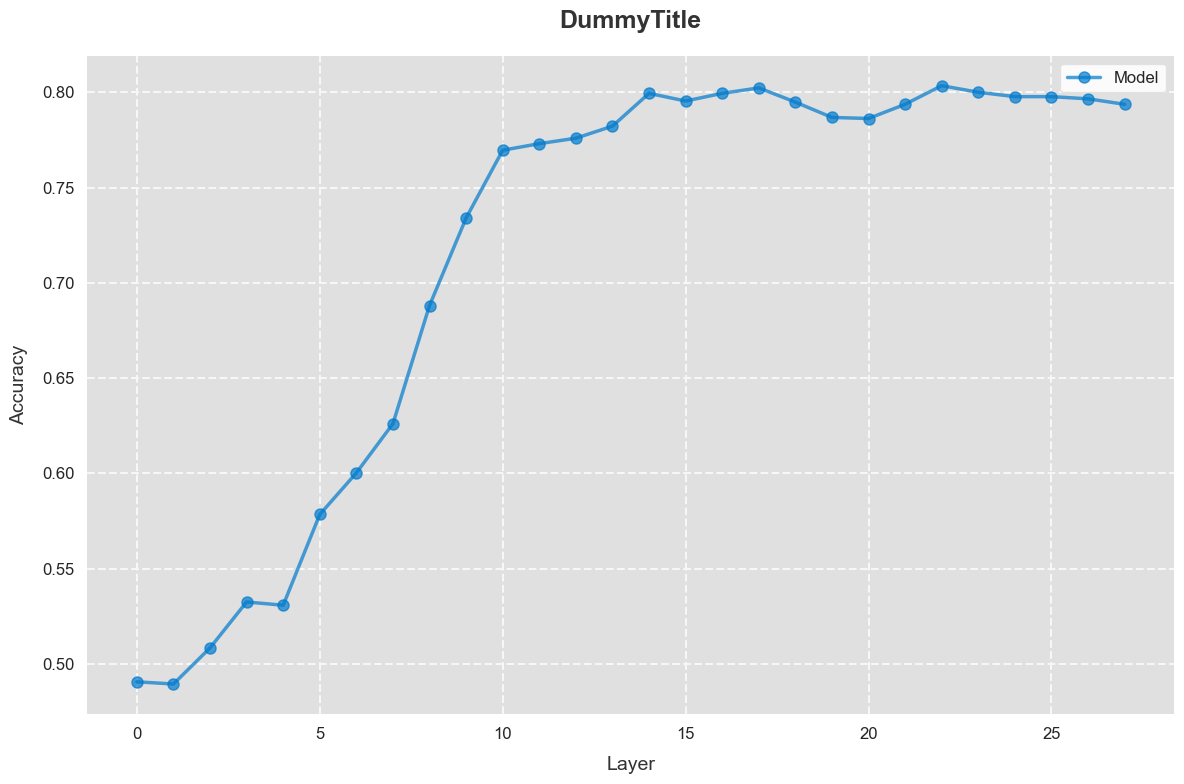

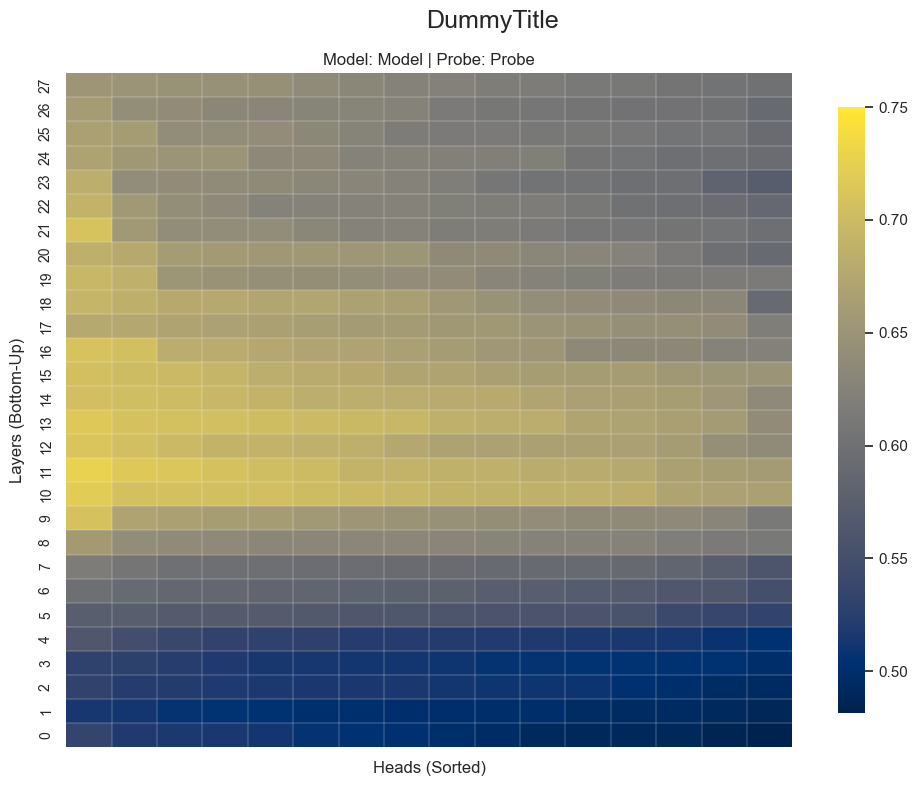

In [29]:
model = 'gpt-j'

heads = t.load(f'accuracy_complete/{model}/logistic_regression/accuracies_heads')
mid = t.load(f'accuracy_complete/{model}/logistic_regression/accuracies_mid')
residual = t.load(f'accuracy_complete/{model}/logistic_regression/accuracies_residual')

plot_line(mid)
plot_line(residual)
plot_heat(heads)

In [76]:
data

[array([-5.49 , -6.715, -4.492, ..., -6.133, -6.723, -6.49 ], dtype=float16),
 array([-4.918,  3.424, -5.633, ..., -4.402, -5.914, -6.23 ], dtype=float16),
 array([-4.387,  4.793, -6.39 , ...,  4.758, -5.426, -6.22 ], dtype=float16),
 array([-6.86 ,  3.734, -4.273, ...,  3.83 , -5.855, -6.305], dtype=float16),
 array([-5.45   , -6.074  ,  1.013  , ..., -0.10614, -1.011  , -2.691  ],
       dtype=float16),
 array([-3.787, -3.908,  0.759, ...,  4.61 ,  1.56 , -3.348], dtype=float16),
 array([ 4.312, -5.56 ,  2.186, ...,  4.535,  0.781, -2.72 ], dtype=float16),
 array([ 1.907  , -4.773  , -0.12494, ...,  4.375  , -5.957  , -1.106  ],
       dtype=float16),
 array([ 1.29 , -5.348,  2.643, ...,  4.69 , -4.51 , -2.762], dtype=float16),
 array([ 4.8   , -5.332 ,  4.293 , ...,  4.39  , -2.73  , -0.4587],
       dtype=float16),
 array([ 3.922 , -5.08  ,  4.355 , ...,  2.18  , -0.4944, -0.565 ],
       dtype=float16),
 array([ 5.207  , -3.578  ,  4.312  , ..., -0.4556 , -0.01031, -1.173  ],
    

In [37]:
data_np = np.array([x.detach().cpu().numpy() if isinstance(x, t.Tensor) else x for x in data])

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [33]:
data_np

array([[0.49798966, 0.49798966, 0.49798966, ..., 0.49798966, 0.49798966,
        0.49798966],
       [0.49052269, 0.49798966, 0.49798966, ..., 0.49798966, 0.5066054 ,
        0.50143596],
       [0.49798966, 0.49798966, 0.49798966, ..., 0.49798966, 0.49798966,
        0.49798966],
       ...,
       [0.49798966, 0.49798966, 0.47501436, ..., 0.69557725, 0.61458932,
        0.62377944],
       [0.67662263, 0.68064331, 0.65422171, ..., 0.62377944, 0.65364733,
        0.74325101],
       [0.65709362, 0.70476738, 0.74210224, ..., 0.75186674, 0.63871338,
        0.74784607]])

In [11]:
# Logical - easy
with open(f'data/datasets/coherence/curated_dataset_full.pkl', 'rb') as file:
    curated_dataset = pickle.load(file)
with open(f'data/datasets/coherence/conj_dataset.pkl', 'rb') as file:
    conj_dataset = pickle.load(file)
with open(f'data/datasets/coherence/neg_dataset.pkl', 'rb') as file:
    neg_dataset = pickle.load(file)

In [12]:
neg_dataset['filename'].unique()

array(['neg_common_claim_true_false.csv', 'neg_companies_true_false.csv',
       'neg_counterfact_true_false.csv'], dtype=object)

In [56]:
def get_data_split(task: str, curated_dataset, probe_config, other_dataset=None, cutoff=1500):


    if task in ['negation', 'disjunction', 'conjunction']:
        # In this case curated dataset is the logical dataset + the remainder
        remainder = curated_dataset[~curated_dataset['filename'].isin(['common_claim_true_false.csv', 'companies_true_false.csv', 'counterfact_true_false.csv'])]
        curated_dataset = pd.concat([remainder, other_dataset])
        train_set, test_set = train_test_split(curated_dataset, test_size=0.2, random_state=42, stratify=curated_dataset['filename'])
        test_df = test_set.dropna()
        
    elif task == 'inference':
        remainder = curated_dataset[~curated_dataset['filename'].isin(['common_claim_true_false.csv', 'companies_true_false.csv', 'counterfact_true_false.csv',
                                                                      'cities.csv', 'cities_cities_conj.csv', 'cities_cities_disj.csv', 'neg_cities.csv'
                                                                      ])]
        curated_dataset = pd.concat([remainder, other_dataset])
        train_set, test_set = train_test_split(curated_dataset, test_size=0.2, random_state=42, stratify=curated_dataset['filename'])
        test_df = test_set.dropna()
        

    # Trim for batch size
    train_set = train_set.iloc[:-(len(train_set) % probe_config), :]
    X_clean_train = list(train_set['statement'])
    y_clean_train = list(train_set['label'])
    
    return (X_clean_train, y_clean_train, test_df)